# Towards Data Science Blog Posts: Topic Modeling with Latent Dirichlet Allocation & MALLET
## Bigram Models 
### *Create and select a topic model, then classify each document according to the dominant topic. Once classified, explore the relationship between topics and the target variable, claps* 
Based on the tutorial at https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [55]:
# !pip install gensim==3.8.3

In [126]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet

# NTLK stopwords
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#saving models
import pickle 
import joblib

import warnings
warnings.filterwarnings("ignore")

In [127]:
#update stopwords with frequent irrelevant words identified during EDA
stop_words = stopwords.words('english')
stop_words.extend(['use', 'used', 'using', 'one', 'like', 'user', 'make', 'also', 'get', 'point', 'let', 'go'])

In [128]:
filename = '../data/tds_cleaned_no_outliers.csv'

In [129]:
#read in the data
df = pd.read_csv(filename)

In [130]:
df.columns

Index(['Unnamed: 0', 'date', 'title', 'subtitle', 'claps', 'responses',
       'author_url', 'story_url', 'reading_time (mins)', 'number_sections',
       'section_titles', 'number_paragraphs', 'paragraphs', 'len_paragraphs',
       'len_title', 'days_live'],
      dtype='object')

In [131]:
#remove non-text, non-Y columns
df = df.drop(columns=['date', 'responses', 'author_url',
       'story_url', 'reading_time (mins)', 'number_sections', 
       'number_paragraphs','len_paragraphs',
       'len_title', 'days_live','Unnamed: 0'])

#### Combine Title & Subtitle

In [133]:
df['combined_title'] = (df['title'] + ' ' + df['subtitle'])

In [134]:
df = df.drop(columns = ['title', 'subtitle']).reset_index(drop=True)

#### Remove Punctuation & Make Lowercase

In [135]:
text_cols = ['section_titles', 'paragraphs', 'combined_title']

In [136]:
for col in text_cols:
    df[col] = df[col].map(lambda x: re.sub("[''·,\.!?'-]", '', x).lower())

#### Remove the 'Min Read' Phrase at the Beginning of Each Paragraph

In [137]:
#remove all text up to and including 'min read' in the beginning of the paragraphs
df['paragraphs'] = df['paragraphs'].map(lambda x: (x[x.index('min read')+9:] if (x.count('min read') > 0) else x))
                     

#### Remove the Brackets Surrounding The Section Titles

In [138]:
#remove brackets surrounding the section titles
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("[",""))
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("]",""))

#### Combine Text Columns

In [139]:
df['text'] = df['combined_title'] + df['section_titles'] + df['paragraphs']

In [140]:
df = df.drop(columns = ['section_titles', 'paragraphs', 'combined_title'])

In [141]:
# Convert to list
data = df['text'].values.tolist()

#### Tokenize Words and Clean Up Text

In [73]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

#### Bigram and Trigram Models

In [74]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [75]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Remove Stop Words 

In [76]:
data_words_nostops = remove_stopwords(data_words)

#### Initialize Spacy 'en' Model

In [77]:
#!spacy download en_core_web_lg

In [78]:
nlp = spacy.load('en_core_web_lg')

In [79]:
# remove exception from rule-based exceptions - not a fan of "datum" showing up in my corpus along with data....
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["data"] = ["data"]

#### Lemmatize

In [80]:
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])

#### Form Bigrams & Trigrams

In [81]:
data_words_bigrams = make_bigrams(data_lemmatized)

In [82]:
data_words_trigrams = make_trigrams(data_lemmatized)

### Bigram Modeling

#### Create the Dictionary & Corpus Needed for Topic Modeling

In [83]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [29]:
#check out the dictionary

id2word[0]

'abbreviate'

### Build an LDA Model

Start with standard gensim LDA model

In [30]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [31]:
doc_lda = lda_model[corpus]

### Evaluate Topic Model

#### Compute Model Perplexity and Coherence Score

In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.232203979273113

Coherence Score:  0.4472422515860178


Recent studies have "shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated."[*source*](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Perplexity%20as%20well%20is%20one,used%20for%20language%20model%20evaluation.&text=The%20concept%20of%20topic%20coherence,topics%20inferred%20by%20a%20model.) 

To put it plainly - optimizing for perplexity will not optimize for human interpretability, so in keeping with the spirit of this investigation, I will focus on coherence score to evaluate topic quality. 

Baseline coherence score is 0.455 with gensim's standard LDA algorithm, but the literature indicates that the LDA mallet algorithm may perform better. 

#### Visualize

In [33]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_LDA_10_bigrams.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.011733 -0.011033       1        1  17.920252
3      0.054281 -0.180097       2        1  15.271716
7     -0.004594  0.179027       3        1  11.784854
1     -0.033649  0.001675       4        1  11.420529
8      0.158117  0.204257       5        1   9.896291
5     -0.149477  0.001599       6        1   9.606202
6     -0.074248  0.036955       7        1   8.509386
2     -0.132620 -0.083003       8        1   6.034746
0      0.280724 -0.117673       9        1   4.825952
9     -0.110267 -0.031706      10        1   4.730071, topic_info=          Term           Freq          Total Category  logprob  loglift
242      model   60849.000000   60849.000000  Default  30.0000  30.0000
80        data  115227.000000  115227.000000  Default  29.0000  29.0000
940      image   18972.000000   18972.000000  Default  28.0000  28.0000
933   function   25816.000000   25816.000000  Default  27.0000  27.0000
416       word   11384.000000   11384.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
23     article    1499.132529   17525.200639  Topic10  -5.1185   0.5925
1661     state    1283.929170    7442.176408  Topic10  -5.2734   1.2940
1299     score    1242.864252    5310.254222  Topic10  -5.3059   1.5990
327     search    1219.239327    4636.901540  Topic10  -5.3251   1.7154
405     vector    1220.530479    5860.203052  Topic10  -5.3241   1.4823

[745 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1124      2  0.033898  accuracy
1124      4  0.958095  accuracy
1124      6  0.007903  accuracy
2300      1  0.012201    action
2300      2  0.211756    action
...     ...       ...       ...
420       1  0.320856      year
420       2  0.556151      year
420       3  0.044176      year
420       6  0.020809      year
420       8  0.057894      year

[1916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 8, 2, 9, 6, 7, 3, 1, 10])

There is lots of overlap and clustering of topics on the left side of the axes. I will try the Mallet algorithm next to improve topic quality.

### Build LDA Mallet Model

In [34]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.wrappers import LdaMallet

In [87]:
#start with 10 topics & fit model to compare to previous
mallet_path = '/Users/rachelinsler/dsi/downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

#### Evaluate with Coherence Score & Visualization

In [36]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#display coherence score
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.47334305972047197


Coherence score has improved for this 10 topic model using the MALLET algorithm. Let's next visualize the topic spread.

In [86]:
# the pyLDAvis was throwing errors on the mallet model; so I found this code on stackoverflow: https://stackoverflow.com/questions/54684552/issue-with-topic-word-distributions-after-malletmodel2ldamodel-in-gensim
from gensim.models.ldamodel import LdaModel

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [38]:
converted_model = ldaMalletConvertToldaGen(ldamallet)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_LDAmallet_TDS10.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.112306 -0.192075       1        1  11.067871
1     -0.059112  0.101273       2        1   8.632542
2     -0.201435 -0.015683       3        1   9.487799
3      0.107987 -0.167969       4        1  12.582845
4     -0.110058 -0.225680       5        1   9.181223
5      0.068150  0.148249       6        1  11.032672
6      0.034251  0.061788       7        1   7.286298
7      0.277832  0.099369       8        1  10.927703
8     -0.122215  0.109309       9        1  10.591854
9     -0.107706  0.081417      10        1   9.209194, topic_info=          Term           Freq          Total Category  logprob  loglift
242      model   66279.000000   66279.000000  Default  30.0000  30.0000
80        data  126220.000000  126220.000000  Default  29.0000  29.0000
940      image   19748.000000   19748.000000  Default  28.0000  28.0000
933   function   29302.000000   29302.000000  Default  27.0000  27.0000
572    feature   21113.000000   21113.000000  Default  26.0000  26.0000
..         ...            ...            ...      ...      ...      ...
858     update    1907.374166    4845.486135  Topic10  -5.5439   1.4526
338     simple    2158.314111   11570.040109  Topic10  -5.4203   0.7059
488       call    2134.140959   11174.899960  Topic10  -5.4315   0.7294
331        set    2168.674066   19672.922482  Topic10  -5.4155   0.1798
971  parameter    2045.506142    9063.564936  Topic10  -5.4740   0.8964

[966 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
423       7  0.968014      abcd
6798      4  0.999946  academia
1555      1  0.297367    access
1555      5  0.000413    access
1555      6  0.162819    access
...     ...       ...       ...
420       3  0.022182      year
420       4  0.328926      year
420       5  0.493635      year
420       6  0.034069      year
420       7  0.000123      year

[1862 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

The spread of topics has improved for the 10 topic model, but there's a lot of overlap. I will continue using the Mallet algorithm and search over a range of #s of topics to settle on the optimal number, using 
1) coherence score 
2) qualitative evaluation of topic spread/overlap 

as my evaluation metrics.

#### Compute Optimal Number of Topics Based on Coherence

In [84]:
# an adapted version of a function to compute coherence values over a range of total topic numbers
# https://github.com/RaRe-Technologies/gensim/issues/2500

def compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    num_topics_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary,
                                         random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)
        #store the topic model
        joblib.dump(model,f'stored_models/ldamallet_model{num_topics}_big.pkl')
        
    return model_list, coherence_values, num_topics_list

In [88]:
# calculate coherence values over the specific range of numbers of topics

model_list, coherence_values, num_topics_list = compute_coherence_values(dictionary=id2word,all_corpus=corpus,
                                                                         texts=data_words_bigrams,start=4,limit=30, step=2)

#store the results in a dataframe
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

#find the number of topics that corresponds to the maximum coherence value
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

#save this as as the optimal model
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=optimal_num_topics, id2word=id2word, random_seed=42)

In [89]:
#save optimal models
joblib.dump(id2word, f'stored_models/id2word_dictionary_mallet_big.pkl')
joblib.dump(optimal_model,f'stored_models/optimal_ldamallet_model_big.pkl')

['stored_models/optimal_ldamallet_model_big.pkl']

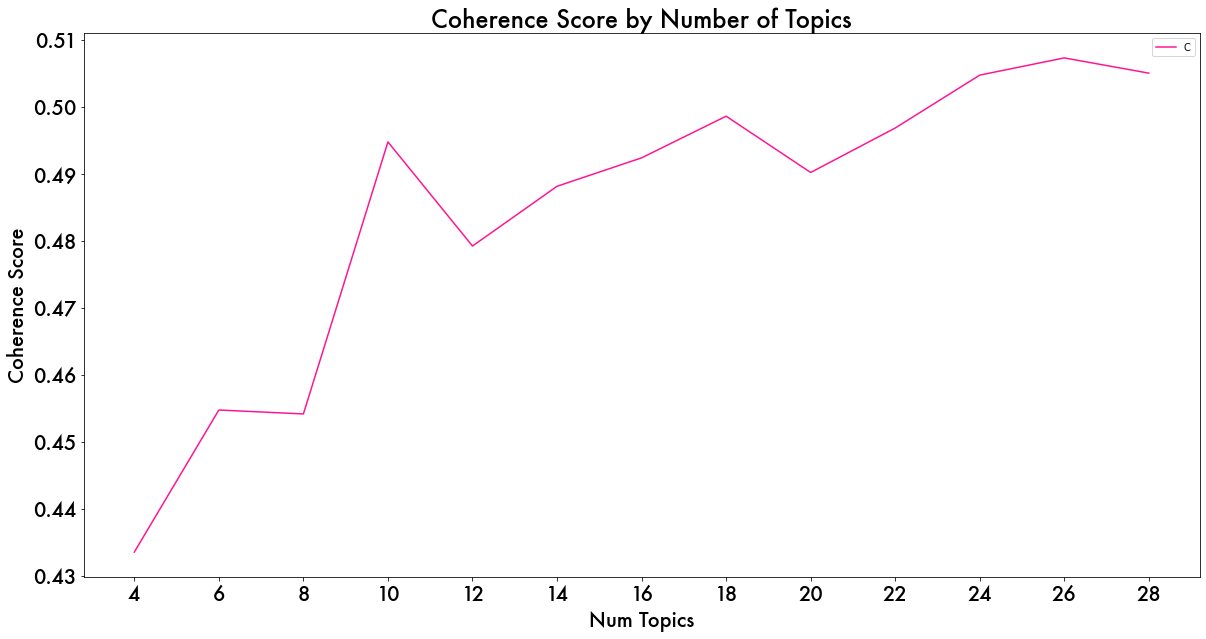

In [90]:
# Show coherence values graph

limit=30; start=4; step=2;
x = range(start, limit, step)
plt.figure(figsize = (20, 10));
sns.lineplot(x=x, y=coherence_values, color='deeppink');
figurefont = {'fontname' : 'Futura'};
plt.title('Coherence Score by Number of Topics', fontsize = 24,**figurefont );
plt.xticks(ticks=range(4,30,2), **figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Num Topics',**figurefont, fontsize = 20);
plt.ylabel('Coherence Score',**figurefont, fontsize = 20);
plt.legend('Coherence Values', loc='best')

plt.savefig('../figures/tds_coherence_bigrams.jpg',  bbox_inches = "tight")

The coherence is highest at 26 topics, followed by 24, and with 18 and 10 close behind.

### Create & Visualize Model with Optimal Number of Topics

In [91]:
optimal_model = joblib.load('stored_models/optimal_ldamallet_model_big.pkl')

#### LDA Mallet Model: 26 Topics

In [92]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5072614233205232


In [93]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model26_big.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.273444  0.087104       1        1  3.709752
1      0.231831  0.033646       2        1  3.289248
2      0.242061  0.129936       3        1  3.751878
3     -0.067195 -0.144217       4        1  3.305347
4      0.074597 -0.125075       5        1  4.950666
5     -0.072562  0.057935       6        1  3.084873
6     -0.151315  0.111447       7        1  3.589525
7      0.019615 -0.101279       8        1  4.586032
8     -0.101081 -0.088614       9        1  2.537651
9     -0.169971  0.061694      10        1  3.505639
10     0.149826 -0.048712      11        1  3.873241
11     0.050815  0.230170      12        1  3.932311
12    -0.109276  0.153583      13        1  3.962541
13    -0.144873 -0.181494      14        1  3.422784
14     0.034139  0.105599      15        1  3.586927
15    -0.175949  0.073717      16        1  4.038195
16    -0.138852  0.091118      17        1  5.615522
17     0.100582 -0.186160      18        1  5.470077
18    -0.089227  0.078298      19        1  3.744660
19    -0.055910  0.049374      20        1  3.872123
20     0.080440 -0.214089      21        1  4.664133
21     0.202896  0.049337      22        1  3.528466
22    -0.029007  0.037644      23        1  3.052621
23    -0.069230  0.043530      24        1  3.644180
24    -0.087054 -0.106800      25        1  2.865954
25     0.001258 -0.197692      26        1  4.415653, topic_info=           Term           Freq          Total Category  logprob  loglift
37         data  126208.000000  126208.000000  Default  30.0000  30.0000
365       model   65363.000000   65363.000000  Default  29.0000  29.0000
2289      image   19373.000000   19373.000000  Default  28.0000  28.0000
295    function   29317.000000   29317.000000  Default  27.0000  27.0000
228        code   26732.000000   26732.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
4     algorithm    1104.483577   14237.451059  Topic26  -5.3552   0.5635
505        year     854.178845    8178.841219  Topic26  -5.6122   0.8608
135     provide     868.770585   11174.095953  Topic26  -5.5952   0.5657
365       model     989.994372   65363.196164  Topic26  -5.4646  -1.0700
688        make     792.444484   13900.891233  Topic26  -5.6872   0.2554

[2501 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3956     19  1.016473  ablation_study
8044      5  0.998704          accent
0         1  0.132333          access
0         2  0.198500          access
0         3  0.129261          access
...     ...       ...             ...
2446      9  0.042355            zone
2446     11  0.076240            zone
2446     25  0.880994            zone
1281      4  0.869790           ztech
3955     13  0.890053           ρ_hat

[6372 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

Decent distribution across the space but more overlap of topics than is optimal. I will explore the other peaks. 

#### LDA Mallet Model: 24 Topics

In [94]:
ldamallet_model = joblib.load('stored_models/ldamallet_model24_big.pkl')

In [95]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.504693069794553


In [96]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(ldamallet_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model24_big.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.002887 -0.117448       1        1  3.342562
1     -0.080276  0.131025       2        1  2.910802
2     -0.187014 -0.019250       3        1  3.944276
3      0.086584  0.109650       4        1  5.947119
4      0.215434 -0.156433       5        1  5.167875
5      0.229874 -0.153736       6        1  4.002870
6      0.133247  0.005114       7        1  4.214894
7     -0.158324 -0.089350       8        1  4.446203
8      0.079290 -0.105111       9        1  3.335756
9     -0.189709 -0.027923      10        1  4.059775
10     0.172631  0.191562      11        1  5.409420
11    -0.157964  0.096954      12        1  3.651586
12     0.076404  0.239756      13        1  4.645964
13     0.017390 -0.158427      14        1  4.106345
14    -0.103471  0.126058      15        1  3.333854
15    -0.035930  0.166642      16        1  3.553285
16    -0.003797 -0.217979      17        1  4.312553
17    -0.040076 -0.043519      18        1  4.039362
18    -0.072076 -0.066041      19        1  4.094927
19    -0.049040  0.026812      20        1  3.314115
20    -0.046591 -0.104472      21        1  5.094176
21     0.152565  0.015158      22        1  4.151061
22    -0.192240 -0.009495      23        1  3.748893
23     0.155974  0.160452      24        1  5.172325, topic_info=            Term           Freq          Total Category  logprob  loglift
365        model   65702.000000   65702.000000  Default  30.0000  30.0000
37          data  126300.000000  126300.000000  Default  29.0000  29.0000
228         code   26505.000000   26505.000000  Default  28.0000  28.0000
2289       image   19398.000000   19398.000000  Default  27.0000  27.0000
295     function   29288.000000   29288.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
220       change    1282.809132   11754.089775  Topic24  -5.3637   0.7467
173   understand    1142.013075   11359.806849  Topic24  -5.4799   0.6646
135      provide    1117.429535   11169.146580  Topic24  -5.5017   0.6597
194     analysis    1106.255210   12097.589829  Topic24  -5.5117   0.5698
401      project    1070.497473   15252.323138  Topic24  -5.5446   0.3052

[2337 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
3956      19  1.015111  ablation_study
1382       4  0.868348           abyss
7313      22  0.996463     accelerator
0          5  0.357089          access
0          9  0.067044          access
...      ...       ...             ...
10971      7  1.006549        youtuber
3456       9  0.874015             yql
6491      23  0.866894      zstatistic
1281      24  0.894911           ztech
3955       8  0.886143           ρ_hat

[5755 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

#### LDA Mallet Model: 18 Topics

In [97]:
ldamallet_model = joblib.load('stored_models/ldamallet_model18_big.pkl')

In [98]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4985614138936643


In [99]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(ldamallet_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model18_big.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.000615  0.172297       1        1  6.453907
1      0.063019  0.161839       2        1  5.773251
2      0.281787  0.090035       3        1  5.342361
3     -0.046115 -0.092394       4        1  5.103406
4     -0.191080  0.078068       5        1  4.996731
5      0.004666 -0.085157       6        1  4.825371
6      0.062183 -0.136862       7        1  4.933159
7      0.001571 -0.163610       8        1  6.361307
8     -0.157327  0.085461       9        1  6.218182
9     -0.138121 -0.070167      10        1  3.770980
10    -0.111019 -0.200585      11        1  6.098015
11    -0.132071  0.211201      12        1  4.747522
12    -0.035107  0.190355      13        1  7.753929
13    -0.007545 -0.182285      14        1  7.627279
14     0.238241  0.120711      15        1  4.786750
15    -0.153638  0.003262      16        1  4.251074
16     0.198857 -0.094728      17        1  5.679983
17     0.121084 -0.087441      18        1  5.276793, topic_info=          Term           Freq          Total Category  logprob  loglift
37        data  126095.000000  126095.000000  Default  30.0000  30.0000
365      model   65430.000000   65430.000000  Default  29.0000  29.0000
295   function   29320.000000   29320.000000  Default  28.0000  28.0000
2289     image   19230.000000   19230.000000  Default  27.0000  27.0000
432    science   17228.000000   17228.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
295   function    2168.039747   29320.982144  Topic18  -4.8589   0.3374
194   analysis    1690.181480   12103.015345  Topic18  -5.1079   0.9732
20        case    1658.248187   15590.250716  Topic18  -5.1270   0.7010
293     follow    1697.024300   19860.213997  Topic18  -5.1038   0.4820
460       step    1577.274551   14940.380376  Topic18  -5.1770   0.6935

[1737 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4414      1  0.984119  absurd
1382     12  0.874596   abyss
0         2  0.250786  access
0         3  0.092105  access
0         5  0.045746  access
...     ...       ...     ...
505      13  0.197811    year
505      14  0.000366    year
505      16  0.121514    year
505      18  0.041561    year
1281      5  0.873686   ztech

[4003 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

#### LDA Mallet Model: 10 Topics

In [100]:
ldamallet_model = joblib.load('stored_models/ldamallet_model10_big.pkl')

In [101]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.494721297323795


In [102]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(ldamallet_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model10_big.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.186927  0.216789       1        1   9.946797
1      0.186755  0.038120       2        1  12.828755
2     -0.081437 -0.192473       3        1   9.687874
3      0.093159 -0.289863       4        1   9.759029
4     -0.168117  0.024786       5        1   9.494639
5     -0.015516  0.101412       6        1   9.610096
6     -0.072167 -0.014465       7        1   7.575460
7      0.181055 -0.042080       8        1   9.543851
8     -0.131795  0.089690       9        1  10.624584
9     -0.178865  0.068084      10        1  10.928916, topic_info=          Term           Freq          Total Category  logprob  loglift
365      model   66418.000000   66418.000000  Default  30.0000  30.0000
37        data  126587.000000  126587.000000  Default  29.0000  29.0000
295   function   29395.000000   29395.000000  Default  28.0000  28.0000
2289     image   19557.000000   19557.000000  Default  27.0000  27.0000
432    science   17402.000000   17402.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
420     result    3616.029060   18199.053245  Topic10  -5.0754   0.5978
336      learn    3455.668225   25281.906195  Topic10  -5.1208   0.2237
75        high    2921.507685    9945.483029  Topic10  -5.2887   0.9887
133    problem    2985.878065   15928.811602  Topic10  -5.2669   0.5395
20        case    2879.723341   15564.731384  Topic10  -5.3031   0.5264

[946 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
1382       1  0.878389         abyss
611        2  1.001134      academia
18180      3  1.001675      accessor
188        5  0.183787      accuracy
188       10  0.816179      accuracy
...      ...       ...           ...
505        2  0.352831          year
505        6  0.350745          year
505        8  0.012641          year
1739       4  0.889989  yettobebuilt
1281       8  0.884842         ztech

[1863 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

This model provides the best balance of spread, disambiguation, and coherence score. 

In [103]:
pyLDAvis.save_html(plot, '../figures/tds_final_LDA_mallet_model10_big.html')


### Find the Dominant Topic in Each Document

In [104]:
pd.set_option('max_colwidth', 100)

In [105]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

def format_topics_docs(ldamodel, corpus=corpus, texts=data_words_bigrams):
    # Init output
    docs_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                docs_topics_df = docs_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),ignore_index=True)
            else:
                break
    docs_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    docs_topics_df = pd.concat([docs_topics_df, contents], axis=1)
    return(docs_topics_df)

In [142]:
df_topic_docs_keywords = format_topics_docs(ldamodel=converted_model, corpus=corpus, texts=data_words_bigrams)

df_dominant_topic=pd.DataFrame()
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#reset index to match df
df_dominant_topic.index = df.index


In [170]:
# show
df_dominant_topic.sort_values('Topic_Perc_Contrib',ascending=False).head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
3954,3954,2.0,0.8861,"function, column, python, data, code, list, method, create, table, type","[useful, thing, know, python, extremely, useful, function, expression, know, python, useful, thi..."
5273,5273,2.0,0.8783,"function, column, python, data, code, list, method, create, table, type","[concept, become, well, python, programmer, learn, operator, arg, concept, become, well, python,..."
3367,3367,2.0,0.8680,"function, column, python, data, code, list, method, create, table, type","[ultimate, guide, list, tuple, array, dictionary, beginner, simple, guide, create, ultimate, gui..."
4868,4868,8.0,0.8664,"probability, distribution, state, function, sample, number, algorithm, give, problem, time","[ultimate, guide, hypothesis, testing, confidence_interval, different, get, ultimate, guide, hyp..."
4224,4224,8.0,0.8619,"probability, distribution, state, function, sample, number, algorithm, give, problem, time","[statistical, foundation, election, poll, random, sampling, binomial, experiment, sampling, dist..."


In [168]:
# Read in unprocessed text
tds = pd.read_csv('../data/tds_nltk_nostem_preproc_strings.csv').drop(columns = ['Unnamed: 0'])

In [184]:
#find the ultimate guide to hypothesis testing post (doc 4868) in the unprocessed text df
tds[(tds['text'].apply(lambda x: x.find('ultimate guide')) < 5) & (tds['text'].apply(lambda x: x.find('ultimate guide')) > -1)]

,claps,text
0,489,ultimate guide acing coding interviews data scientists data science interview ultimate guide aci...
33,13,ultimate guide counterfactual explanations classification models human interpretable… ultimate g...
329,66,ultimate guide hypothesis testing confidence intervals different… getting started ultimate guide...
1004,62,ultimate guide apis data scientists web services 101 ultimate guide apis data scientists web ser...
2992,473,ultimate guide cracking business case interviews data scientists… data science interview ultimat...
4227,300,ultimate guide cracking business case interviews data scientists… data science interview ultimat...
5322,20,ultimate guide column creation pandas dataframes 12 ways creating new columns python ultimate gu...
6405,269,ultimate guide data engineer interviews office hours ultimate guide data engineer interviews res...
6894,84,ultimate guide reinforced learning part 1 — creating game comprehensive article series… ultimate...
6900,94,ultimate guide ai game creation part 2 — training comprehensive article series will… ultimate gu...


In [185]:
tds['text'][329]

'ultimate guide hypothesis testing confidence intervals different… getting started ultimate guide hypothesis testing confidence intervals different scenarios "statistical inference process making reasonable guesses populations distribution parameters given observed data conducting hypothesis testing constructing confidence interval two examples statistical inference hypothesis testing process calculating probability observing sample statistics given null hypothesis true comparing probability (pvalue) significance level (1ɑ) make reasonable guesses population parameters sample taken similar process calculate confidence interval certain confidence level confidence interval interval estimation population parameter point estimation plus minus critical value times sample standard error article discuss standard procedure conducting hypothesis testing estimating confidence intervals following different scenarios:" article served tutorial statistical inference well cheatsheet reference section

#### Find the most representative document for each topic

In [144]:
doc_topics_sorteddf_mallet = pd.DataFrame()


#reset index to match df numbers
df_topic_docs_keywords.index = df.index

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Format
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [145]:
# Show topics, keywords, and most representatives texts
doc_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
7583,0.0,0.7863,"ai, game, system, people, human, world, team, player, make, decision","[global, artificial_intelligence, race, strategic, balance, race, run, global, artificial_intell..."
1878,1.0,0.8392,"data, science, learn, work, scientist, project, machine, good, time, question","[amateur, data, scientist, month, enough, story, data, science, trainer, perspectivefrom, amateu..."
3954,2.0,0.8861,"function, column, python, data, code, list, method, create, table, type","[useful, thing, know, python, extremely, useful, function, expression, know, python, useful, thi..."
5759,3.0,0.8204,"code, file, create, run, python, project, follow, package, app, api","[publish, python, package, pypi, publish, python, packageshow, publish, python, package, pypi, p..."
3031,4.0,0.8326,"image, model, network, layer, training, learning, input, deep, learn, train","[paper, read, deep, image, inpainte, paper, read, deep, image, inpainte, image, inpainte, termin..."
8295,5.0,0.7908,"data, plot, analysis, time, show, cluster, visualization, number, dataset, customer","[exploratory, data, analysis, sao_paulo, policy, murder, report, accord, world, health, explorat..."
673,6.0,0.7220,"word, text, model, language, topic, document, article, sentence, nlp, search","[important, word, text, data, tfidf, answer, article, explain, bag, important, word, text, data,..."
8055,7.0,0.7631,"data, database, system, service, cloud, process, pipeline, tool, query, store","[choose, right, google, cloud, platform, database, cloud, beyond, get, famhow, choose, right, go..."
4868,8.0,0.8664,"probability, distribution, state, function, sample, number, algorithm, give, problem, time","[ultimate, guide, hypothesis, testing, confidence_interval, different, get, ultimate, guide, hyp..."
1333,9.0,0.7877,"model, data, feature, dataset, prediction, machine, predict, set, learning, test","[machine, learning, model, basic, evaluation, metric, method, machine, machine, learning, evalua..."


#### Explore Relationship Between Dominant Topic and Number of Claps

In [146]:
df.head()

,claps,text
0,14,introduction to system design — 1 in the series of post on system design i am writing today abou...
1,15,boosting sales through customer segmentation analysis: knowing the market better customer segmen...
2,19,predicting weekly hotel cancellations with xgbregressor time series forecasting with xgbregresso...
3,57,how i won the santander data master competition — 3 central soft skills i used and the hard skil...
4,31,sentence embeddings and corenlp’s recursive sentiment model getting startedsentence embeddings a...


In [147]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.5690,"data, database, system, service, cloud, process, pipeline, tool, query, store","[introduction, system, design, series, post, system, design, write, today, horizontal, scaling, ..."
1,1,9.0,0.3365,"model, data, feature, dataset, prediction, machine, predict, set, learning, test","[boost, sale, customer, segmentation, analysis, know, market, well, customer, segmentation, boos..."
2,2,9.0,0.5025,"model, data, feature, dataset, prediction, machine, predict, set, learning, test","[predict, weekly, hotel, cancellation, xgbregressor, time, series, forecast, weekly, hotel, canc..."
3,3,1.0,0.6203,"data, science, learn, work, scientist, project, machine, good, time, question","[santander, data, master, competition, central, soft, skill, hard, skill, santander, data, maste..."
4,4,6.0,0.5673,"word, text, model, language, topic, document, article, sentence, nlp, search","[sentence, embedding, corenlp, recursive, sentiment, model, get, startedsentence, embedding, cor..."


In [148]:
#merge on index
combined_df = pd.merge(df,df_dominant_topic, how='inner', left_index=True, right_index=True)

In [149]:
combined_df.columns

Index(['claps', 'text', 'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib',
       'Keywords', 'Text'],
      dtype='object')

In [150]:
combined_df.drop(columns = ['Document_No', 'Text'], inplace=True)


In [151]:
combined_df.head()

,claps,text,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,14,introduction to system design — 1 in the series of post on system design i am writing today abou...,7.0,0.5690,"data, database, system, service, cloud, process, pipeline, tool, query, store"
1,15,boosting sales through customer segmentation analysis: knowing the market better customer segmen...,9.0,0.3365,"model, data, feature, dataset, prediction, machine, predict, set, learning, test"
2,19,predicting weekly hotel cancellations with xgbregressor time series forecasting with xgbregresso...,9.0,0.5025,"model, data, feature, dataset, prediction, machine, predict, set, learning, test"
3,57,how i won the santander data master competition — 3 central soft skills i used and the hard skil...,1.0,0.6203,"data, science, learn, work, scientist, project, machine, good, time, question"
4,31,sentence embeddings and corenlp’s recursive sentiment model getting startedsentence embeddings a...,6.0,0.5673,"word, text, model, language, topic, document, article, sentence, nlp, search"


In [152]:
#the topics are not ordinal, so I will convert them to strings

combined_df['Dominant_Topic'] = combined_df['Dominant_Topic'].apply(lambda x: str(x).strip('.0').zfill(2))


In [153]:
#colum order
new_column_order = combined_df.groupby('Dominant_Topic')['claps'].mean().sort_values().index

In [163]:
combined_df.groupby('Dominant_Topic')['claps'].mean().sort_values()

Dominant_Topic
00     73.798258
05     76.109148
09     82.392675
08     86.374720
04     87.189834
07     90.849367
06     93.408907
02    102.366914
03    105.658700
01    115.802817
Name: claps, dtype: float64

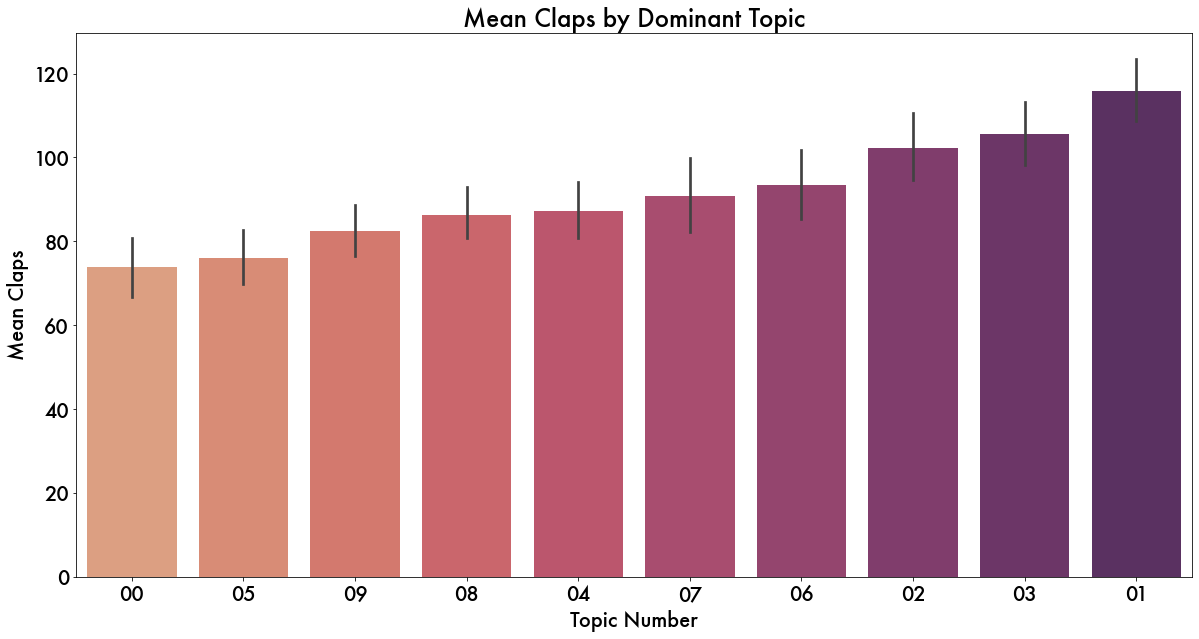

In [154]:
plt.figure(figsize = (20, 10));
sns.barplot(data=combined_df, x='Dominant_Topic', y='claps', order= new_column_order,  palette='flare');
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Claps by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Topic Number',**figurefont, fontsize = 20);
plt.ylabel('Mean Claps',**figurefont, fontsize = 20);
plt.savefig('../figures/tds_mean_claps_bigram_model10.jpg',  bbox_inches = "tight")

In [155]:
combined_df['Dominant_Topic'].value_counts()

01    1278
03    1046
09     983
04     964
05     962
02     943
08     894
07     790
06     741
00     689
Name: Dominant_Topic, dtype: int64

There is good distribution of the topics across the corpus. 

#### Model Claps by Topic

In [156]:
model_df = pd.get_dummies(combined_df,columns=['Dominant_Topic'], drop_first=True)

In [157]:
model_df.columns

Index(['claps', 'text', 'Topic_Perc_Contrib', 'Keywords', 'Dominant_Topic_01',
       'Dominant_Topic_02', 'Dominant_Topic_03', 'Dominant_Topic_04',
       'Dominant_Topic_05', 'Dominant_Topic_06', 'Dominant_Topic_07',
       'Dominant_Topic_08', 'Dominant_Topic_09'],
      dtype='object')

In [158]:
import statsmodels.api as sm

In [159]:
model_df.head()

,claps,text,Topic_Perc_Contrib,Keywords,Dominant_Topic_01,Dominant_Topic_02,Dominant_Topic_03,Dominant_Topic_04,Dominant_Topic_05,Dominant_Topic_06,Dominant_Topic_07,Dominant_Topic_08,Dominant_Topic_09
0,14,introduction to system design — 1 in the series of post on system design i am writing today abou...,0.5690,"data, database, system, service, cloud, process, pipeline, tool, query, store",0,0,0,0,0,0,1,0,0
1,15,boosting sales through customer segmentation analysis: knowing the market better customer segmen...,0.3365,"model, data, feature, dataset, prediction, machine, predict, set, learning, test",0,0,0,0,0,0,0,0,1
2,19,predicting weekly hotel cancellations with xgbregressor time series forecasting with xgbregresso...,0.5025,"model, data, feature, dataset, prediction, machine, predict, set, learning, test",0,0,0,0,0,0,0,0,1
3,57,how i won the santander data master competition — 3 central soft skills i used and the hard skil...,0.6203,"data, science, learn, work, scientist, project, machine, good, time, question",1,0,0,0,0,0,0,0,0
4,31,sentence embeddings and corenlp’s recursive sentiment model getting startedsentence embeddings a...,0.5673,"word, text, model, language, topic, document, article, sentence, nlp, search",0,0,0,0,0,1,0,0,0


In [160]:
X = model_df.drop(columns=['text','claps','Keywords', 'Topic_Perc_Contrib'])
X = sm.add_constant(X, prepend=True)
y = model_df['claps']

In [161]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  claps   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     13.60
Date:                Wed, 12 May 2021   Prob (F-statistic):           6.21e-22
Time:                        21:21:12   Log-Likelihood:                -57288.
No. Observations:                9290   AIC:                         1.146e+05
Df Residuals:                    9280   BIC:                         1.147e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                73.7983      4.396     16.789      0.000      65.182      82.415
Dominant_Topic_01    42.0046      5.453      7.702      0.000      31.315      52.694
Dominant_Topic_02    28.5687      5.783      4.940      0.000      17.233      39.904
Dominant_Topic_03    31.8604      5.661      5.628      0.000      20.763      42.958
Dominant_Topic_04    13.3916      5.756      2.326      0.020       2.108      24.675
Dominant_Topic_05     2.3109      5.759      0.401      0.688      -8.977      13.599
Dominant_Topic_06    19.6106      6.106      3.211      0.001       7.641      31.581
Dominant_Topic_07    17.0511      6.015      2.835      0.005       5.261      28.841
Dominant_Topic_08    12.5765      5.849      2.150      0.032       1.111      24.042
Dominant_Topic_09     8.5944      5.733      1.499      0.134      -2.643      19.832
==============================================================================
Omnibus:                     4600.987   Durbin-Watson:                   1.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26348.647
Skew:                           2.387   Prob(JB):                         0.00
Kurtosis:                       9.729   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As one might expect, there is quite a bit more going on influencing claps beyond just the dominant topic in an abstract. 